In [1]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Загружаем обработанный в прошлой ЛР датасет

In [2]:
data = pd.read_csv('out.csv')

In [3]:
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4472.0,106.216259,55.861038,0.850535,4642.0,75.458116,0.775312,274.486,0.745884,1.901437,1.0
1,3951.0,100.022328,52.476331,0.851320,4085.0,70.926507,0.563784,253.792,0.770834,1.906047,1.0
2,4621.0,107.515859,56.390835,0.851418,4798.0,76.704889,0.658262,277.531,0.753916,1.906619,1.0
3,4709.0,107.830578,56.550030,0.851451,4801.0,77.431809,0.824405,265.248,0.841074,1.906817,1.0
4,4581.0,106.597203,55.874881,0.851615,4685.0,76.372183,0.565625,266.221,0.812242,1.907784,1.0


In [4]:
X = data.drop("Class", axis=1).to_numpy()
y = data["Class"].to_numpy()

print(X.shape)
print(y.shape)

type(X)

(17863, 10)
(17863,)


numpy.ndarray

In [5]:
print(X[:5])

[[4.47200000e+03 1.06216259e+02 5.58610379e+01 8.50535305e-01
  4.64200000e+03 7.54581158e+01 7.75312067e-01 2.74486000e+02
  7.45883950e-01 1.90143727e+00]
 [3.95100000e+03 1.00022328e+02 5.24763306e+01 8.51320389e-01
  4.08500000e+03 7.09265073e+01 5.63784247e-01 2.53792000e+02
  7.70834311e-01 1.90604654e+00]
 [4.62100000e+03 1.07515859e+02 5.63908351e+01 8.51417512e-01
  4.79800000e+03 7.67048886e+01 6.58262108e-01 2.77531000e+02
  7.53915776e-01 1.90661938e+00]
 [4.70900000e+03 1.07830578e+02 5.65500303e+01 8.51451051e-01
  4.80100000e+03 7.74318088e+01 8.24404762e-01 2.65248000e+02
  8.41074214e-01 1.90681733e+00]
 [4.58100000e+03 1.06597203e+02 5.58748808e+01 8.51614663e-01
  4.68500000e+03 7.63721831e+01 5.65625386e-01 2.66221000e+02
  8.12242173e-01 1.90778399e+00]]


Разбиваю на обучающую и тестовую выборку, после чего нормализую данные

In [6]:
from sklearn.preprocessing import normalize

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

train_X = normalize(train_X, norm="max", axis=0)
test_X = normalize(test_X, norm="max", axis=0)

print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

(14290, 10)
(14290,)
(3573, 10)
(3573,)


In [7]:
class Layer:
    def forward(self, *args):
        pass

    def backward(self, *args):
        pass


class Softmax(Layer):
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z

    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)


class CrossEntropyLoss(Layer):
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()

    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p


class BinaryCrossEntropy(Layer):
    def forward(self, p, y):
        y = y.reshape((y.shape[0], 1))
        self.p = p
        self.y = y
        res = y * np.log(p) + (1 - y) * np.log(1 - p)
        return -np.mean(res)

    def backward(self, loss):
        res = (self.p - self.y) / (self.p * (1 - self.p))
        return res / self.p.shape[0]


class Linear(Layer):
    def __init__(self, nin, nout):
        sigma = 1.0 / np.sqrt(2.0 * nin)
        self.W = np.random.normal(0, sigma, (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx

    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db


class Tanh(Layer):
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy


class ReLU(Layer):
    def forward(self, x):
        self.x = x
        return x * (x > 0)

    def backward(self, dy):
        return (1. * (self.x > 0)) * dy


class Sigmoid(Layer):
    def forward(self, x):
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, dy):
        return self.y * (1.0 - self.y) * dy


class Net:
    def __init__(self, loss=CrossEntropyLoss()):
        self.layers = []
        self.loss_ = loss

    def add(self, l: Layer):
        self.layers.append(l)

    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z

    def update(self, lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss_.forward(p, y)
        pred = np.argmax(p, axis=1)
        acc = (pred == y).mean()
        return l, acc

    def train_epoch(self, train_x, train_labels, batch_size=4, lr=0.1):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i + batch_size]
            yb = train_labels[i:i + batch_size]

            p = self.forward(xb)
            l = self.loss_.forward(p=p, y=yb)
            dp = self.loss_.backward(loss=l)
            dx = self.backward(z=dp)
            self.update(lr)


class SoftMarginSVM(Net):
    def __init__(self, nin, alpha):
        super().__init__()
        self.alpha = alpha
        sigma = 1.0 / np.sqrt(nin)
        self.W = np.random.normal(0., sigma, (1, nin + 1))

    def forward(self, x):
        z = np.dot(x, self.W.T)
        return z

    # Добавляет столбец из единиц
    def add_ones(self, x):
        ones = np.ones((x.shape[0], 1))
        return np.hstack((x, ones))

    def predict(self, x):
        res = self.forward(self.add_ones(x))
        return np.where(res < 0, 0, 1)

    def train_epoch(self, x, y, batch_size=100, step=1e-7):
        x = self.add_ones(x)
        y = np.where(y > 0, 1, -1)
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]

            pred = self.forward(xb)
            grad = self.alpha * self.W
            for i in range(len(xb)):
                if (yb[i] * pred[i] < 1):
                    grad -= yb[i] * xb[i]
            self.W -= step * grad

In [9]:
from math import pi
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay


def scores(model, X, y_true):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    figure = plt.figure(figsize = (20, 5))
    matr = confusion_matrix(y_true, y_pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true = y_true, y_pred = y_pred, name = "ROC-кривая", ax = ax)
    plt.show()


def best(model):
    print("Best params:", model.best_params_)
    print("Best acc:", model.best_score_)


class kNN(BaseEstimator, ClassifierMixin):

    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        y = np.ndarray((X.shape[0],))
        for (i, elem) in enumerate(X):
            distances = euclidean_distances([elem], self.X_)[0]
            indexes = np.argsort(distances, kind='heapsort')

            indexes = indexes[:self.k]
            labels, cnts = np.unique(self.y_[indexes], return_counts=True)
            y[i] = labels[cnts.argmax()]
        return y


class LogisticRegression(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches=1, batch_size=10, SGD_step=0.001, nin=10):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.nin = nin
        self.Net = Net(BinaryCrossEntropy())
        self.Net.add(Linear(nin, 1))
        self.Net.add(Sigmoid())

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        y = self.Net.forward(X)
        res = np.where(y < 0.5, 0, 1)
        return res

    def getW(self):
        return self.Net.layers[0].W

    def getb(self):
        return self.Net.layers[0].b


class SVM(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches=1, batch_size=10, SGD_step=0.001, alpha=0.1, nin=10):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.nin = nin
        self.alpha = alpha
        self.Net = SoftMarginSVM(nin, alpha)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        y = self.Net.predict(X)
        return y

    def getW(self):
        return self.Net.W


class NaiveBayes(ClassifierMixin, BaseEstimator):
    def __init__(self):
        None

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True

        labels, cnts = np.unique(self.y_, return_counts=True)
        self.labels = labels
        self.p_of_y = np.array([elem / self.y_.shape[0] for elem in cnts])
        self.means = np.array([self.X_[self.y_ == elem].mean(axis=0) for elem in labels])
        self.stds = np.array([self.X_[self.y_ == elem].std(axis=0) for elem in labels])
        # Return the classifier
        return self

    def gaussian(self, mu, sigma, x0):
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * pi * sigma)

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        res = np.zeros(X.shape[0])
        for (i, elem) in enumerate(X):
            p = np.array(self.p_of_y)
            for (j, label) in enumerate(self.labels):
                p_x_cond_y = np.array(
                    [self.gaussian(self.means[j][k], self.stds[j][k], elem[k]) for k in range(X.shape[1])])
                p[j] *= np.prod(p_x_cond_y)
            res[i] = np.argmax(p)
        return res

In [10]:
gscv = GridSearchCV(Pipeline([('knn', kNN())]), {'knn__k' : [1, 3, 5, 7, 9]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'knn__k': 7}
Best acc: 0.9887333799860041


Accuracy: 0.9907640638119227
Recall: 0.994982438534872
Precision: 0.9885343968095713


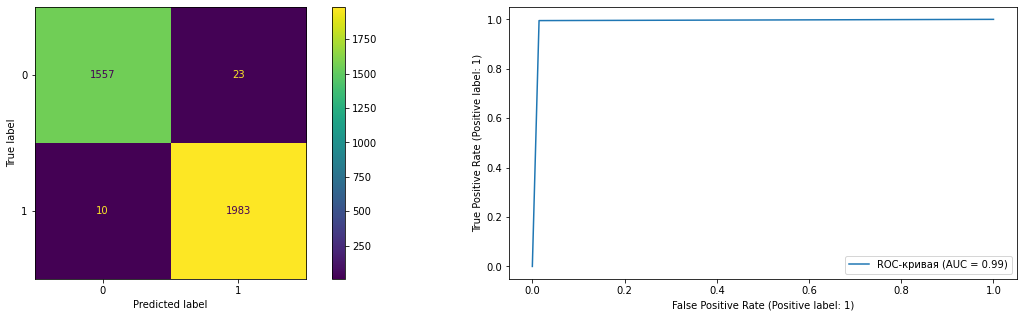

In [11]:
knn_best = gscv.best_estimator_
scores(knn_best, test_X, test_y)

In [12]:
f = open("kNN.pkl", "wb")
pickle.dump(gscv.best_estimator_, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [13]:
from sklearn.neighbors import KNeighborsClassifier

gscv = GridSearchCV(Pipeline([('knn', KNeighborsClassifier())]), {'knn__n_neighbors' : [1, 3, 5, 7, 9]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'knn__n_neighbors': 7}
Best acc: 0.9887333799860041


Accuracy: 0.9907640638119227
Recall: 0.994982438534872
Precision: 0.9885343968095713


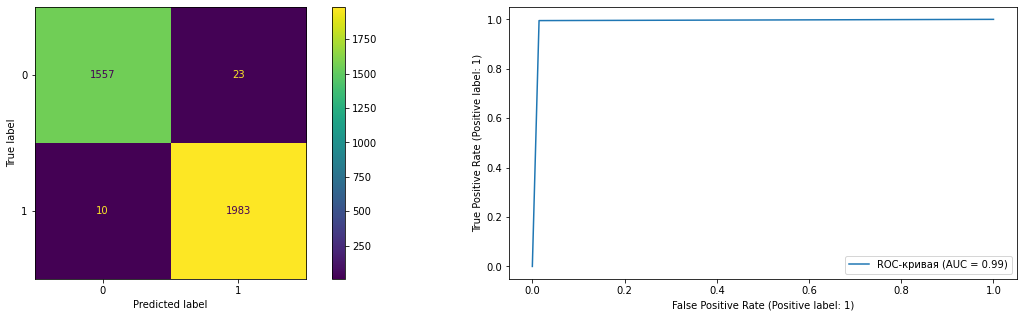

In [14]:
knn_best = gscv.best_estimator_
scores(knn_best, test_X, test_y)

In [15]:
gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression(nin=train_X.shape[1]))]),
                    {"logreg__epoches" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__SGD_step" : [0.01, 0.05, 0.1]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'logreg__SGD_step': 0.1, 'logreg__batch_size': 5, 'logreg__epoches': 4}
Best acc: 0.984884534639608


Accuracy: 0.9860061572907921
Recall: 0.9979929754139488
Precision: 0.9773955773955774


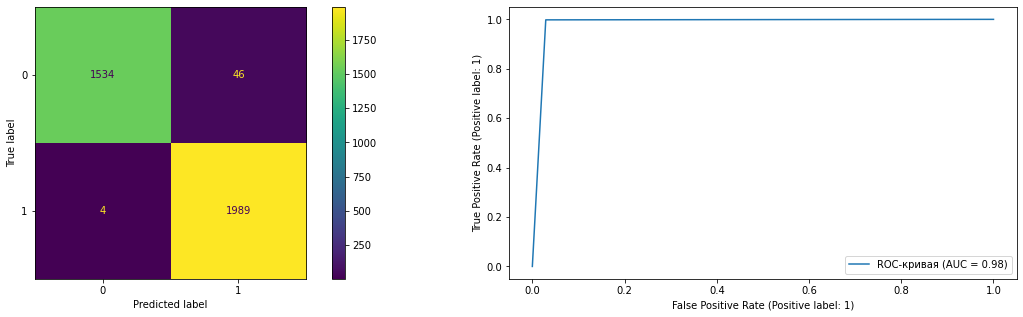

In [16]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)

Accuracy: 0.9860061572907921
Recall: 0.9979929754139488
Precision: 0.9773955773955774


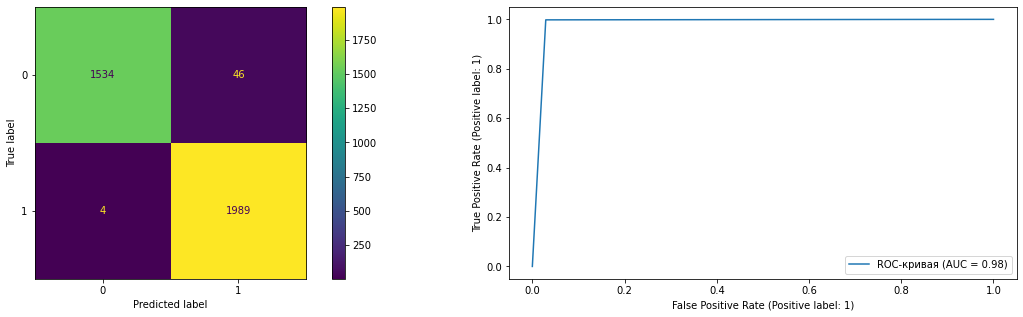

In [17]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)

In [18]:
rscv = RandomizedSearchCV(Pipeline([("logreg", LogisticRegression(nin=train_X.shape[1]))]),
                    {"logreg__epoches" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__SGD_step" : [0.01, 0.05, 0.1]})
rscv.fit(train_X, train_y)
best(rscv)

Best params: {'logreg__epoches': 4, 'logreg__batch_size': 5, 'logreg__SGD_step': 0.05}
Best acc: 0.9836948915325403


Accuracy: 0.9857262804366079
Recall: 0.9979929754139488
Precision: 0.9769155206286837


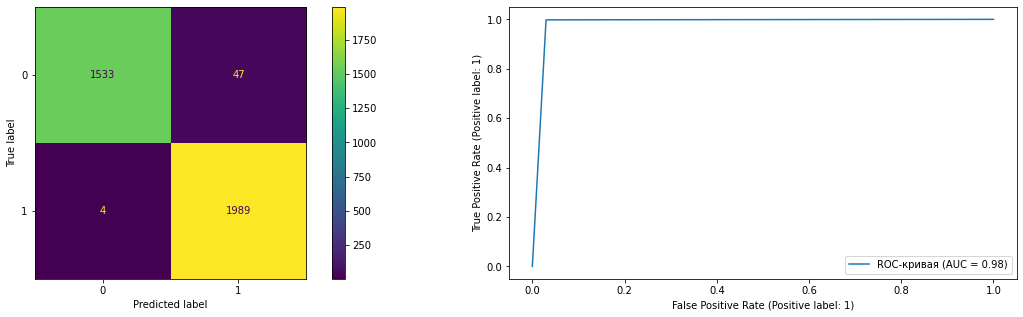

In [19]:
logreg_best = rscv.best_estimator_
scores(logreg_best, test_X, test_y)

In [20]:
f = open("logreg.pkl", "wb")
pickle.dump(logreg_best, f, pickle.HIGHEST_PROTOCOL)
f.close()

[Логистическая регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из scikit-learn

In [21]:
from sklearn.linear_model import LogisticRegression

gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression())]),
                    {"logreg__penalty" : ["l2", "none"],
                     "logreg__solver" : ["newton-cg", "lbfgs"],
                     "logreg__max_iter" : [1000, 10000]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'logreg__max_iter': 1000, 'logreg__penalty': 'none', 'logreg__solver': 'newton-cg'}
Best acc: 0.9898530440867738


Accuracy: 0.8905681500139938
Recall: 1.0
Precision: 0.8359899328859061


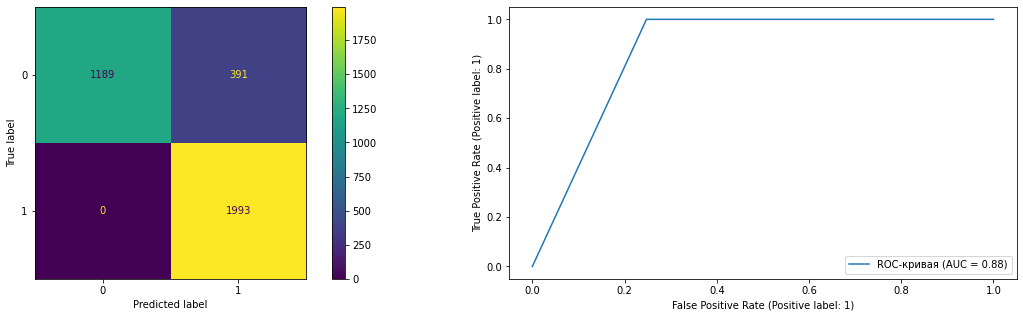

In [22]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)

In [23]:
gscv = GridSearchCV(Pipeline([("SVM", SVM(nin=train_X.shape[1]))]),
                    {"SVM__epoches" : [1, 2, 4],
                     "SVM__batch_size" : [5, 10, 20],
                     "SVM__SGD_step" : [0.01, 0.05, 0.1],
                     "SVM__alpha" : [1.0, 0.1, 0.01, 0.0]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'SVM__SGD_step': 0.01, 'SVM__alpha': 0.01, 'SVM__batch_size': 20, 'SVM__epoches': 4}
Best acc: 0.980265920223933


Accuracy: 0.9809683739154772
Recall: 0.9994982438534872
Precision: 0.967459932005828


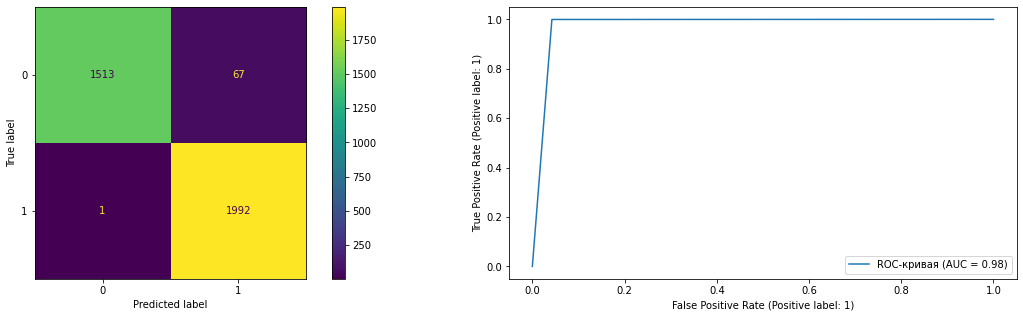

In [24]:
SVM_best = gscv.best_estimator_
scores(SVM_best, test_X, test_y)

Функция для отрисовки разделяющей прямой

In [25]:
def drawDataAndLine(W, b, X, y):
    n = X.shape[1]
    fig, ax = plt.subplots(n, n)
    for i in range(n):
        for j in range(n):
            ax[i][j].set_xlim(0.0, 1.0)
            ax[i][j].set_ylim(0.0, 1.0)
            if i==j:
                continue
            x_list0 = []
            y_list0 = []

            x_list1 = []
            y_list1 = []
            for (ii, elem) in enumerate(X):
                if (y[ii] == 1):
                    x_list1.append(elem[i])
                    y_list1.append(elem[j])
                elif (y[ii] == 0):
                    x_list0.append(elem[i])
                    y_list0.append(elem[j])
            ax[i][j].scatter(x_list1, y_list1, s = 10)
            ax[i][j].scatter(x_list0, y_list0, s = 10)

            line_x = np.linspace(0.0, 1.0, 100)
            line_y = -(W[i] * line_x + b) / W[j]
            ax[i][j].plot(line_x, line_y, "-r")
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()

In [26]:
f = open("SVM.pkl", "wb")
pickle.dump(SVM_best, f, pickle.HIGHEST_PROTOCOL)
f.close()

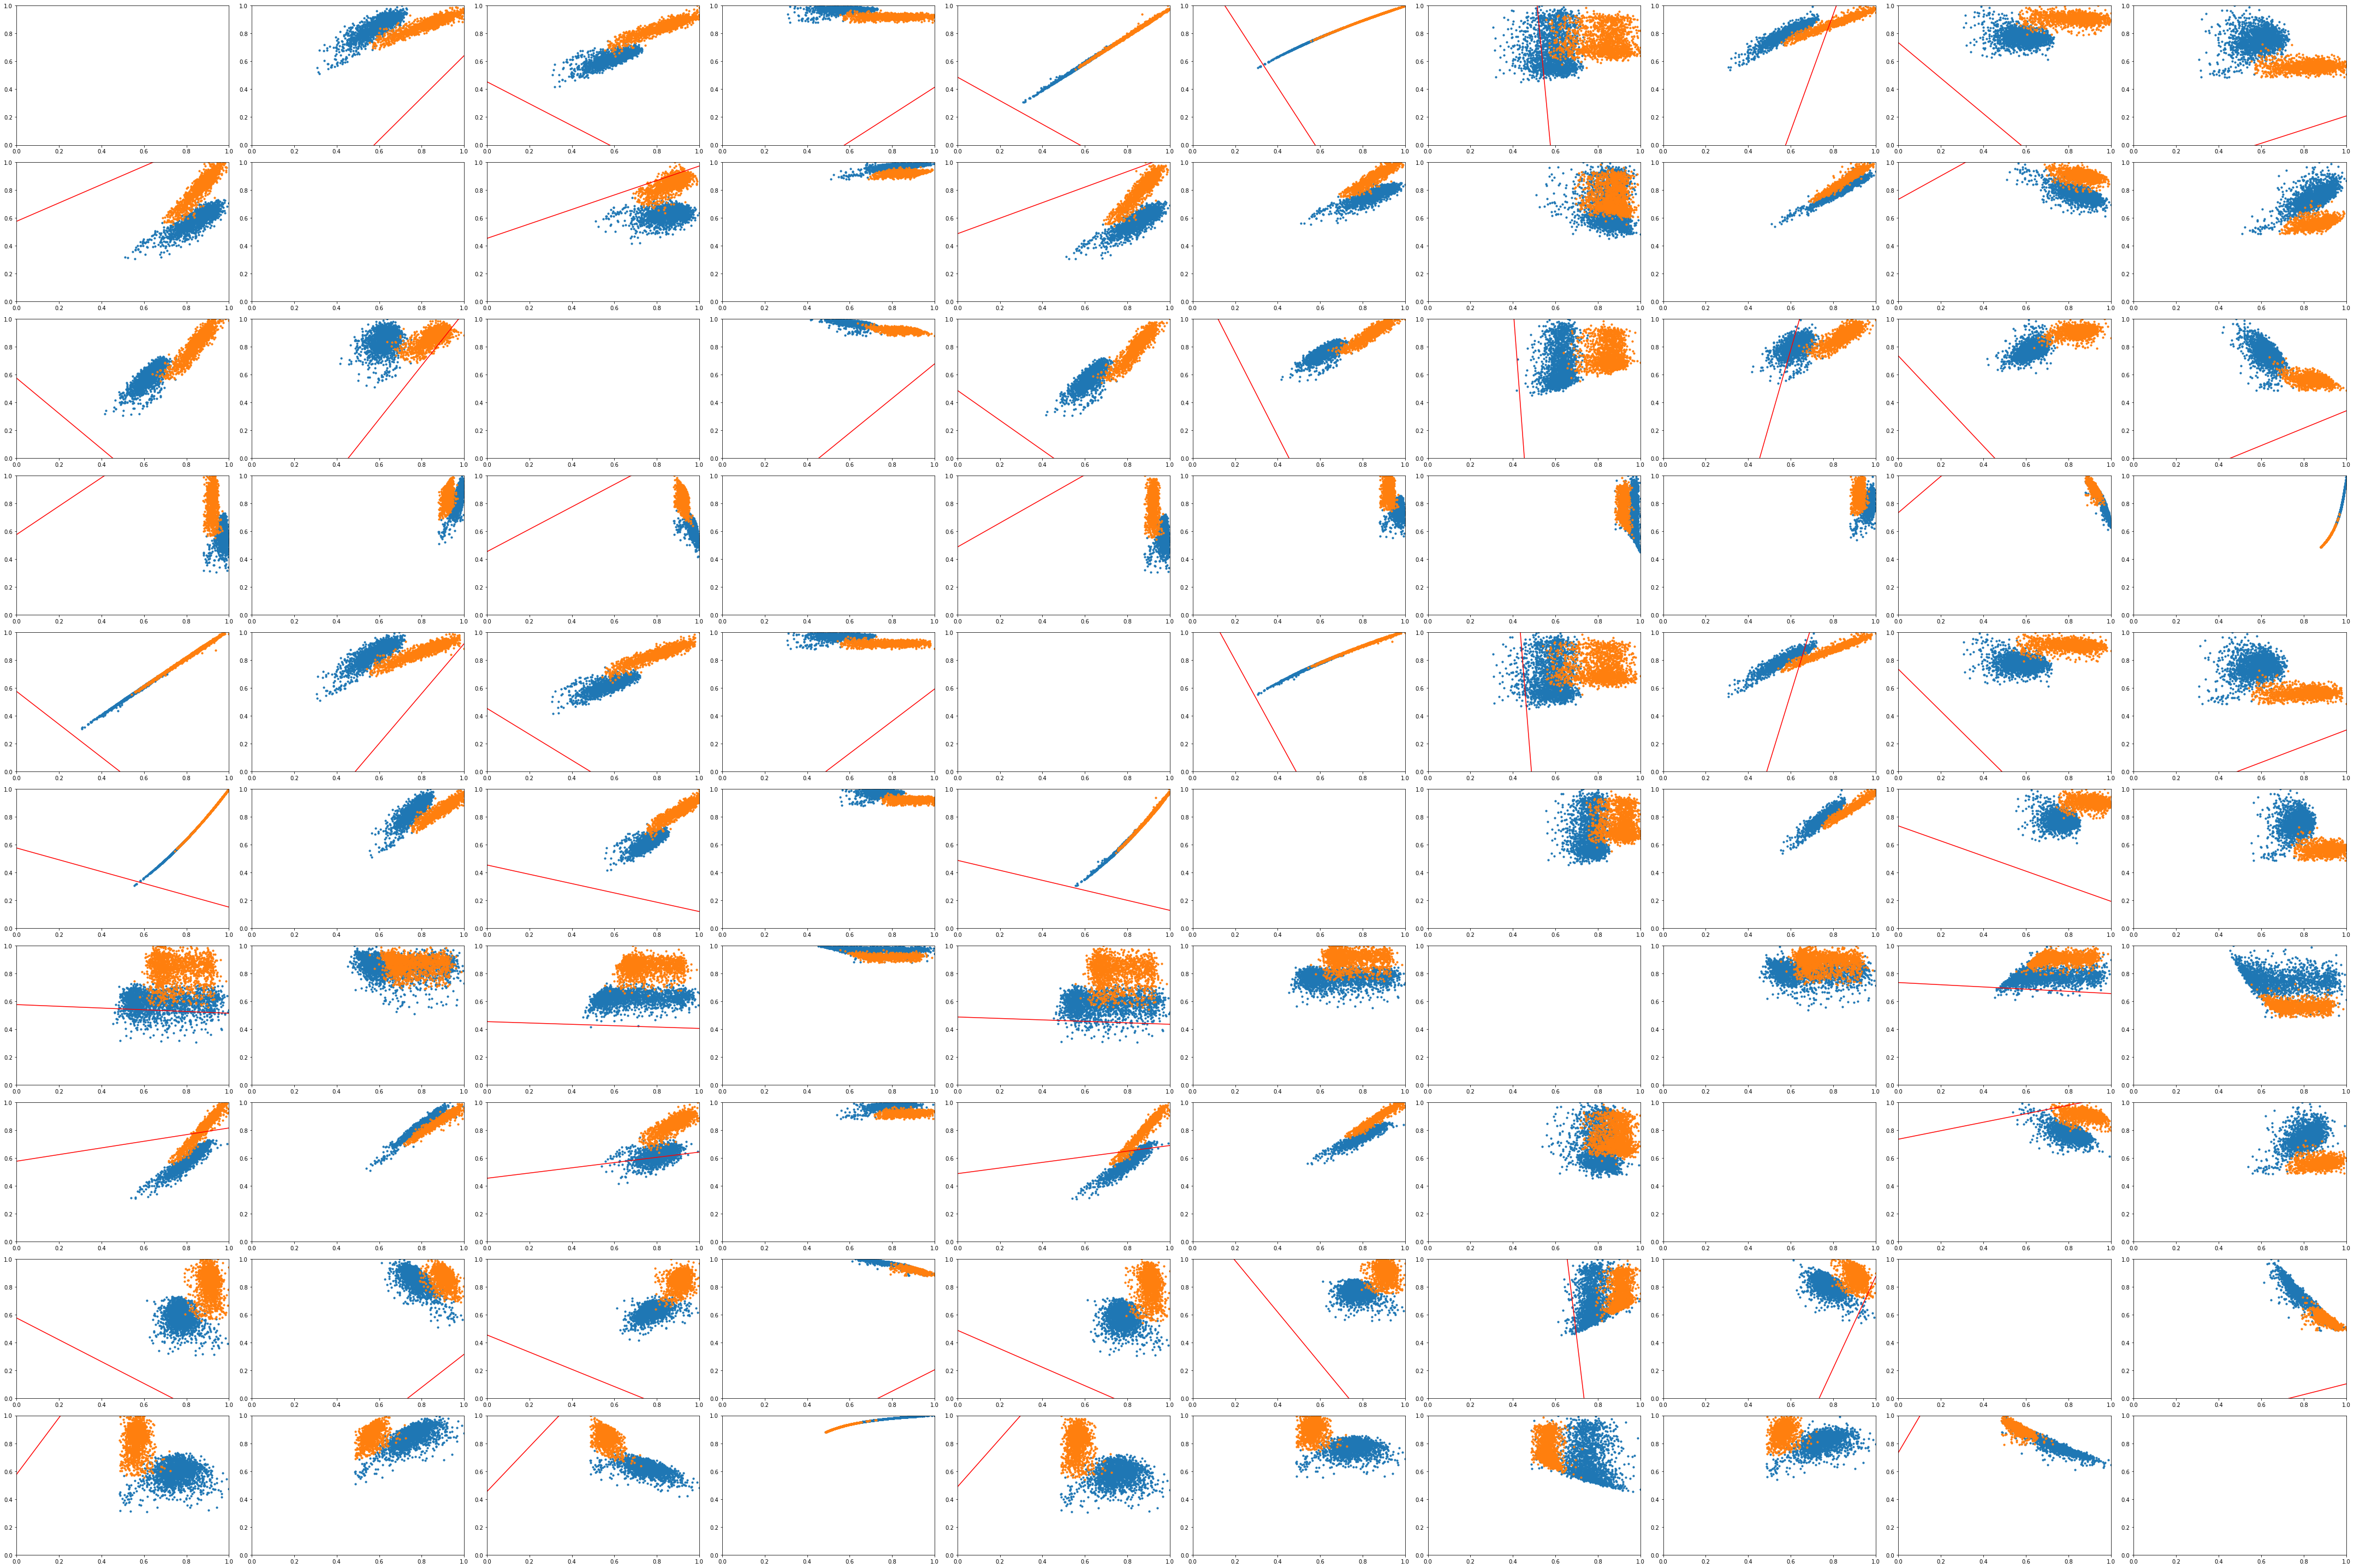

In [27]:
SVM_params = SVM_best[0].getW()
drawDataAndLine(SVM_params[0][:10], SVM_params[0][-1], test_X, test_y)

In [28]:
rscv = RandomizedSearchCV(Pipeline([("SVM", SVM(nin=train_X.shape[1]))]),
                    {"SVM__epoches" : [1, 2, 4],
                     "SVM__batch_size" : [5, 10, 20],
                     "SVM__SGD_step" : [0.01, 0.05, 0.1],
                     "SVM__alpha" : [1.0, 0.1, 0.01, 0.0]})
rscv.fit(train_X, train_y)
best(rscv)

Best params: {'SVM__epoches': 2, 'SVM__batch_size': 20, 'SVM__alpha': 1.0, 'SVM__SGD_step': 0.01}
Best acc: 0.9774667599720084


Accuracy: 0.9678141617688217
Recall: 1.0
Precision: 0.9454459203036053


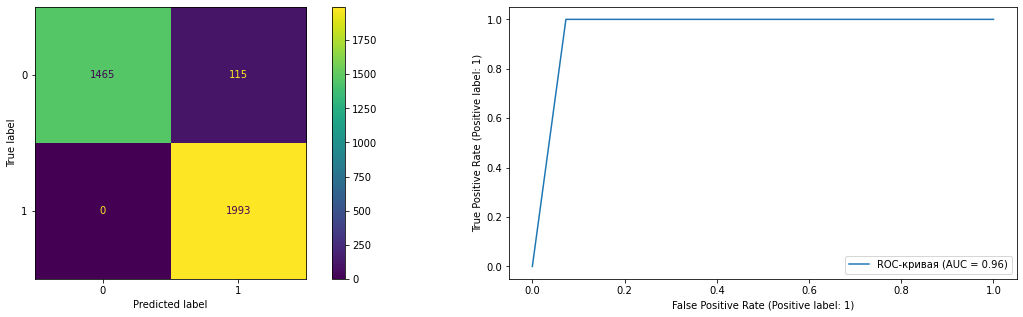

In [29]:
SVM_best = rscv.best_estimator_
scores(SVM_best, test_X, test_y)

In [30]:
from sklearn.svm import LinearSVC

gscv = GridSearchCV(Pipeline([("svc", LinearSVC())]),
                    {"svc__loss" : ["hinge", "squared_hinge"],
                     "svc__max_iter" : [1e5, 1e6]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'svc__loss': 'squared_hinge', 'svc__max_iter': 100000.0}
Best acc: 0.987893631910427


Accuracy: 0.9888049258326337
Recall: 0.9954841946813848
Precision: 0.9846153846153847


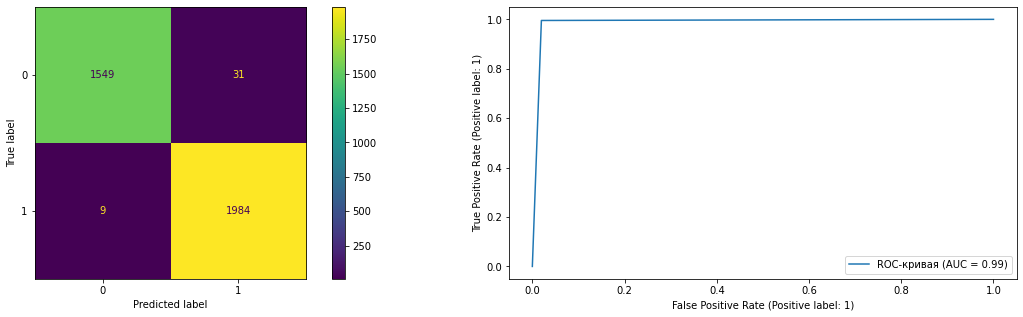

In [31]:
SVM_best = gscv.best_estimator_
scores(SVM_best, test_X, test_y)

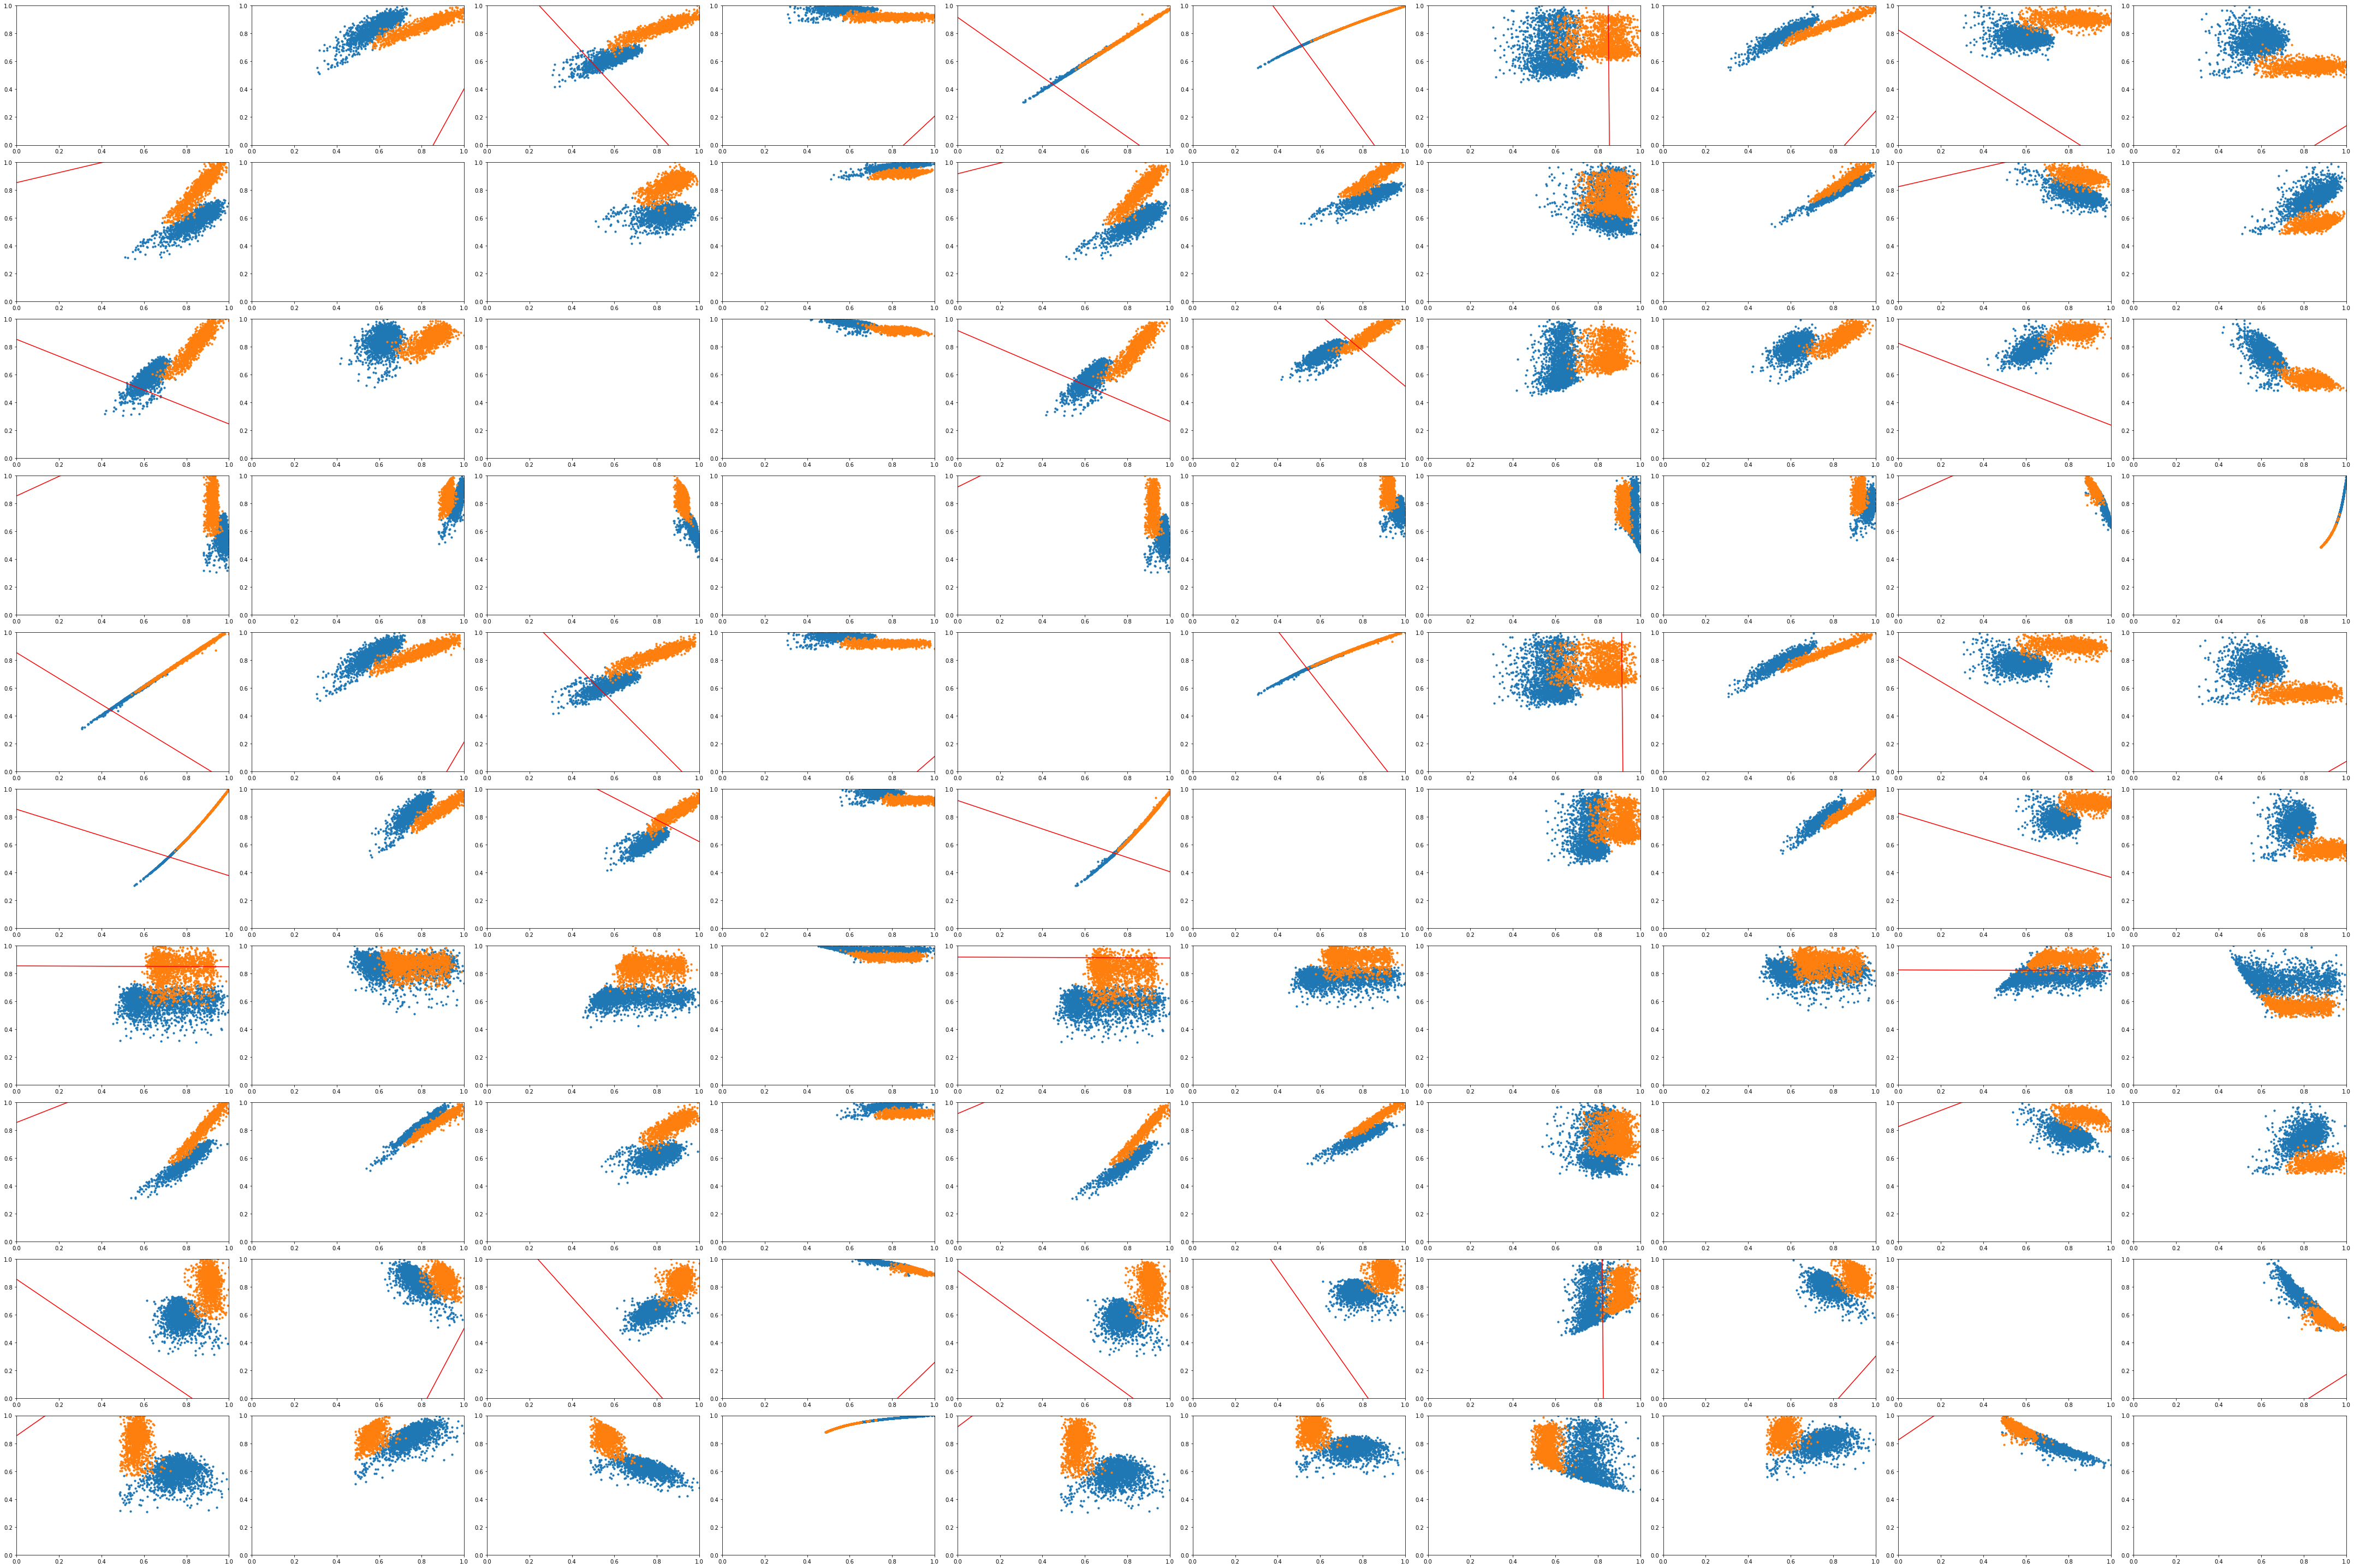

In [32]:
drawDataAndLine(SVM_best[0].coef_[0], SVM_best[0].intercept_[0], test_X, test_y)

Accuracy: 0.9860061572907921
Recall: 0.9959859508278976
Precision: 0.9792797237296498


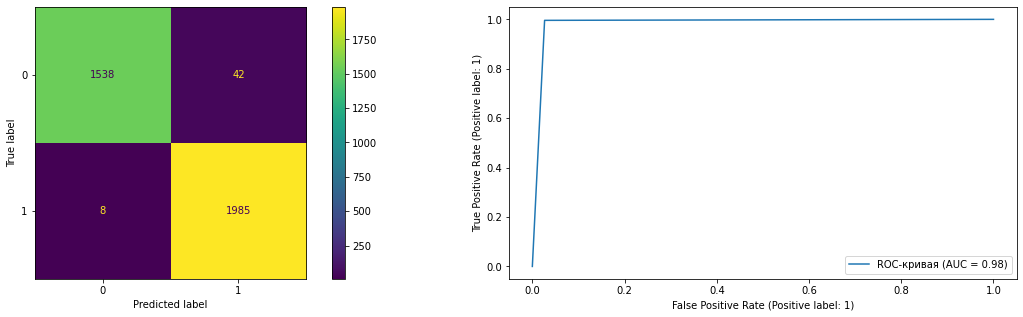

In [33]:
NB = Pipeline([("NB", NaiveBayes())])
NB.fit(train_X, train_y)
scores(NB, test_X, test_y)

In [34]:
f = open("NB.pkl", "wb")
pickle.dump(NB, f, pickle.HIGHEST_PROTOCOL)
f.close()

Accuracy: 0.9851665267282396
Recall: 0.9984947315604616
Precision: 0.9754901960784313


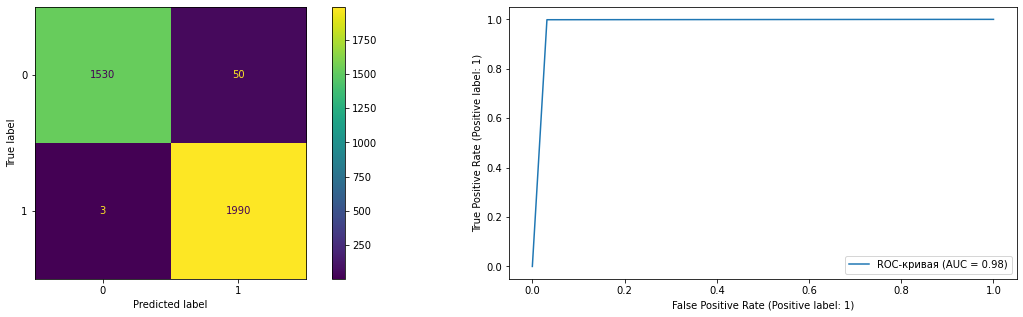

In [35]:
from sklearn.naive_bayes import GaussianNB

NB = Pipeline([("NB", GaussianNB())])
NB.fit(train_X, train_y)
scores(NB, test_X, test_y)